## Imports

In [16]:
import numpy as np
import pandas as pd
import joblib, pickle
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, balanced_accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import FunctionTransformer, Pipeline
import matplotlib.pyplot as plt

## Data Loading

Here we load a semicolon-delimited credit-default dataset, set a folder for saving trained models, build the feature matrix by dropping the non-informative ID and the target column, earmarks categorical attributes and selected repayment-status fields for later preprocessing, and then create a reproducible 80/20 train-test.


In [17]:
df = pd.read_csv('./assets/Dataset3.csv', sep=';')
MODEL_DIR = Path("./assets/models")

X = df.drop(['ID', 'default.payment.next.month'], axis=1)
y = df['default.payment.next.month']

dummy_cols = ['SEX', 'EDUCATION', 'MARRIAGE']  # categorical features
pay_cols = [f'PAY_{i}' for i in [0, 2, 3, 4, 5, 6]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#### Definition of preprocessing pipelines

With these blocks we set up the numerical-feature preprocessing strategy for the forthcoming model: we first craft a **signed log transform** to tame heavy-tailed positives and negatives. Then we declare the set of highly skewed "BILL\_AMT" and "PAY\_AMT" variables targeted for that treatment. Finally we assemble two pipelines-one for those skewed amounts (impute missing values with 0 -> apply the signed log -> robust-scale to kill remaining outliers) and one for the more regular ordinal features (impute with the mode -> standard-scale). In short, we are laying down clean, robust numeric inputs before any learning algorithm ever sees the data.


In [18]:
def signed_log_transform(X):
    """
    Apply signed log transformation to the input data.
    """
    return np.sign(X) * np.log1p(np.abs(X))

In [19]:
skew_feats = [f'BILL_AMT{i}' for i in range(1, 7)] + \
             [f'PAY_AMT{i}'  for i in range(1, 7)]

# Pipeline: impute 0 → log1p → RobustScaler
skew_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('log', FunctionTransformer(func=signed_log_transform, feature_names_out='one-to-one')),
    ('rscale', RobustScaler())
])

ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

## Evaluation Functions

With this block we equip ourselves with a mini "assessment lab" for any classifier we train: we first define `evaluate`, which lets us audit the model on both train and test splits in one call, reporting a full slate of threshold-based metrics (accuracy, precision, recall, F1) plus probability-based AUC. We add `evaluate_balanced` to focus on class-imbalance balanced accuracy and the area under the precision-recall curve, useful when defaults are rare.<br>
Finally, the two `plot_*` helpers draw the precision-recall and ROC curves, giving us visual feedback on the trade-off between false alarms and missed defaults. In short, this code sets up a repeatable, data-rich way for us to judge whether our model genuinely generalises and how it behaves across different operating points.


In [ ]:
def evaluate(model, X_tr, X_te, y_tr, y_te, label):
    print("\n" + "=" * 30, label, "=" * 30)
    for split, (X_split, y_split) in (("Train", (X_tr, y_tr)),
                                      ("Test",  (X_te, y_te))):
        y_pred = model.predict(X_split)
        y_prob = model.predict_proba(X_split)[:, 1]
        print(f"[{split}] "
              f"Accuracy={accuracy_score(y_split, y_pred):.3f} | "
              f"Precision={precision_score(y_split, y_pred):.3f} | "
              f"Recall={recall_score(y_split, y_pred):.3f} | "
              f"F1={f1_score(y_split, y_pred):.3f} | "
              f"AUC={roc_auc_score(y_split, y_prob):.3f}")
    print("\nConfusion matrix (Test):")
    print(confusion_matrix(y_te, model.predict(X_te)))
    print("\nClassification report (Test):")
    print(classification_report(y_te, model.predict(X_te), digits=3))

def evaluate_balanced(model, X, y, label="Test"):
    """
    Print Balanced-Accuracy e PR-AUC (media precision-recall area).
    """
    y_pred  = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    bal_acc = balanced_accuracy_score(y, y_pred)
    pr_auc  = average_precision_score(y, y_proba)

    print(f"[{label}] Balanced-Acc={bal_acc:.3f} | PR-AUC={pr_auc:.3f}")

def plot_pr_auc(model, X, y, label="Test"):
    y_proba = model.predict_proba(X)[:, 1]
    pr_auc = average_precision_score(y, y_proba)
    precision, recall, _ = precision_recall_curve(y, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='PR Curve')
    plt.title(f'Precision-Recall Curve ({label}) - PR AUC: {pr_auc:.3f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid()
    plt.show()

# plot auc-roc
def plot_auc_roc(model, X, y, label="Test"):
    y_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.title(f'ROC Curve ({label})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()



## Complete pipeline: Random Forest with all features

With this cell we run a **complete modeling cycle** for the credit-default task.<br>
First, we spell out how each group of features will be cleaned and scaled, then bundle those transformations into a single `ColumnTransformer`. Next, we nest that pre-processor inside a `RandomForestClassifier` and launch a **randomized hyper-parameter search** over 50 candidate forests, using 5-fold **stratified CV** and the **average-precision score** (PR-AUC) as the objective, exactly the metric we care about when the positive class is scarce. Once the search locks onto the most promising parameter set, we **refit the best model on the whole training split**, report the chosen hyper-parameters, and subject the final estimator to a battery of quantitative checks (accuracy, F1, balanced accuracy, PR-AUC) plus diagnostic plots of the PR and ROC curves. In short, this code moves us from raw, heterogeneous features to a fully tuned, performance-vetted Random Forest ready for deployment or further comparison.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:
{'rf__n_estimators': 500, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 20, 'rf__max_samples': None, 'rf__max_features': 0.5, 'rf__max_depth': 15, 'rf__class_weight': 'balanced'}

============================== Random Forest - ALL features ==============================
[Train] Accuracy=0.831 | Precision=0.602 | Recall=0.699 | F1=0.647 | AUC=0.901
[Test] Accuracy=0.789 | Precision=0.521 | Recall=0.585 | F1=0.551 | AUC=0.774

Confusion matrix (Test):
[[3959  714]
 [ 551  776]]

Classification report (Test):
              precision    recall  f1-score   support

           0      0.878     0.847     0.862      4673
           1      0.521     0.585     0.551      1327

    accuracy                          0.789      6000
   macro avg      0.699     0.716     0.707      6000
weighted avg      0.799     0.789     0.793      6000

[Test] Balanced-Acc=0.716 | PR-AUC=0.550


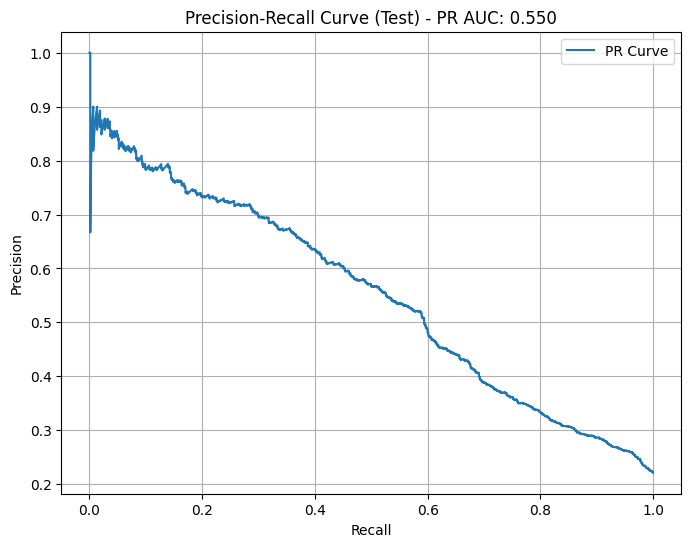

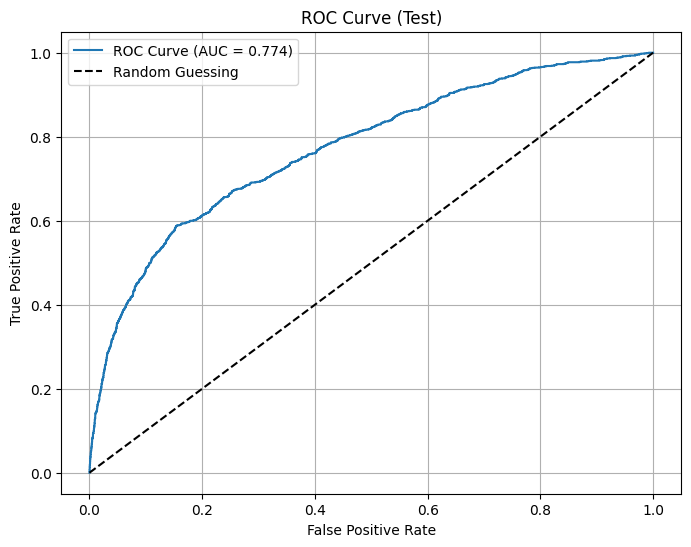

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Feature definition
categorical_features = dummy_cols
numeric_features = [c for c in X_train.columns if c not in categorical_features]

# Subset of numeric features that are not skewed that will be standardized
numeric_other = [c for c in numeric_features if c not in skew_feats + pay_cols]


preprocessor = ColumnTransformer([
    ('skew', skew_pipe, skew_feats),
    ('num', StandardScaler(), numeric_other),
    ('ord', ordinal_pipe, pay_cols),
    ('cat', OneHotEncoder(
        drop='first',
        handle_unknown='ignore',
        sparse_output=False,
        min_frequency=2
    ), categorical_features)
])

rf_base = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
pipe_rf = Pipeline([
    ('prep', preprocessor),
    ('rf', rf_base)
])

param_dist = {
    "rf__n_estimators": list(range(400, 1001, 100)),
    "rf__max_depth":    [None, 15, 20, 25, 30],
    "rf__max_features": ["sqrt", "log2", 0.5, None],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf":  [5, 10, 20],
    "rf__class_weight":  ["balanced", "balanced_subsample"],
    "rf__max_samples":   [None, 0.8, 0.6]
}

rf_search = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

print("Best parameters found:")
print(rf_search.best_params_)

evaluate(best_rf, X_train, X_test, y_train, y_test,
         label="Random Forest - ALL features")
evaluate_balanced(best_rf, X_test, y_test)
plot_pr_auc(best_rf, X_test, y_test, label="Test")
plot_auc_roc(best_rf, X_test, y_test, label="Test")

## Complete pipeline: Random Forest with Lasso feature selection

With this block we **shrink the feature space and fine-tune a new Random Forest in one shot**: we prepend the previous preprocessing to an L1-penalised logistic model that keeps roughly half the variables (lasso selection), pipe the surviving columns into a forest, and grid-search both the lasso strength and the forest’s main hyper-parameters under 5-fold stratified CV, optimising PR-AUC.  After refitting the best combo on the full training split, we list the features that survived the lasso, then judge the final model on hold-out data with the same metric suite and the accompanying PR and ROC curves, confirming that a leaner, more interpretable feature set attains virtually the same predictive quality (PR-AUC ≈ 0.55, ROC-AUC ≈ 0.78) as the full model.

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Feature selected: ['skew__BILL_AMT1' 'skew__PAY_AMT1' 'skew__PAY_AMT2' 'skew__PAY_AMT3'
 'skew__PAY_AMT4' 'skew__PAY_AMT6' 'num__LIMIT_BAL' 'num__AGE'
 'ord__PAY_0' 'ord__PAY_2' 'ord__PAY_3' 'ord__PAY_4' 'ord__PAY_5'
 'ord__PAY_6' 'cat__MARRIAGE_1']
Best parameters found:
{'rf__max_depth': 15, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 10, 'rf__n_estimators': 600, 'sel__estimator__C': np.float64(0.01)}

============================== Random Forest - after Lasso ==============================
[Train] Accuracy=0.828 | Precision=0.596 | Recall=0.691 | F1=0.640 | AUC=0.896
[Test] Accuracy=0.788 | Precision=0.520 | Recall=0.580 | F1=0.548 | AUC=0.776

Confusion matrix (Test):
[[3962  711]
 [ 558  769]]

Classification report (Test):
              precision    recall  f1-score   support

           0      0.877     0.848     0.862      4673
           1      0.520     0.580     0.548      1327

    accuracy              

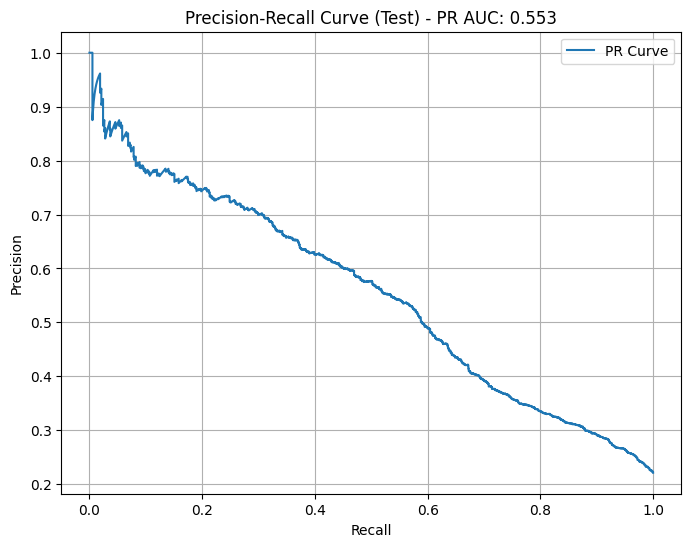

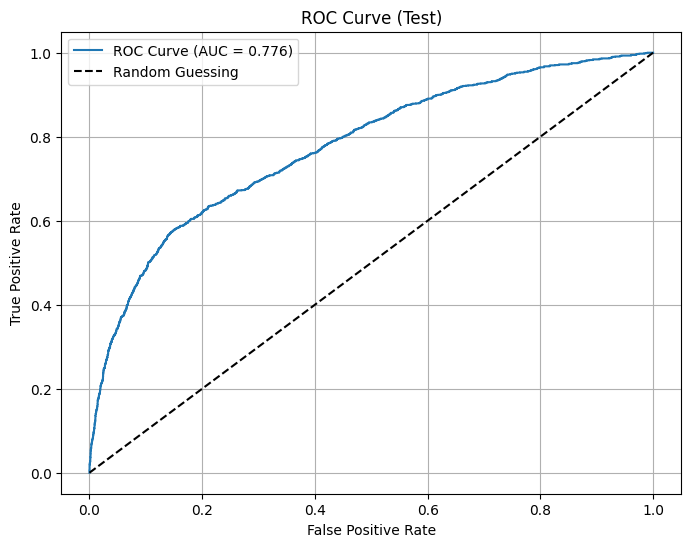

In [22]:
pipe_lasso_rf = Pipeline([
    ('prep', preprocessor),
    ('sel',  SelectFromModel(
                 LogisticRegression(penalty='l1',
                                    solver='saga',
                                    class_weight='balanced',
                                    max_iter=5000),
                 threshold='median',
                 max_features=30)),
    ('rf',   rf_base)
])

param_grid_lasso_rf = {
    # Lasso
    'sel__estimator__C':  np.logspace(-2, 1, 6),
    # Random Forest
    'rf__n_estimators':   [600, 800],
    'rf__max_depth':      [15, 20, 25],
    'rf__min_samples_leaf': [5, 10],
    'rf__max_features':   ['sqrt', 0.5]
}

search_lasso_rf = GridSearchCV(
    pipe_lasso_rf,
    param_grid_lasso_rf,
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

search_lasso_rf.fit(X_train, y_train)
best_rf_sel = search_lasso_rf.best_estimator_

sel_step   = best_rf_sel.named_steps['sel']
prep_step  = best_rf_sel.named_steps['prep']

mask = sel_step.get_support()
feat = prep_step.get_feature_names_out()
print("Feature selected:", feat[mask])

print("Best parameters found:")
print(search_lasso_rf.best_params_)

evaluate(best_rf_sel, X_train, X_test, y_train, y_test,
         label="Random Forest - after Lasso")
evaluate_balanced(best_rf_sel, X_test, y_test)
plot_pr_auc(best_rf_sel, X_test, y_test, label="Test")
plot_auc_roc(best_rf_sel, X_test, y_test, label="Test")


## Plots

We put the two candidate pipelines, the full-feature Random Forest and the lean "RF + Lasso" version, through a final, side-by-side diagnostic:

1. **Balanced-accuracy bar chart:** we compute the metric on the held-out data and visualise it as a simple two-bar comparison. Both bars land at ≈ 0.71, confirming that the pruning step neither helps nor hurts class-balanced performance.

2. **Precision–recall overlay:** we score each model’s posterior probabilities, draw both PR curves on the same axes, and annotate the areas (PR-AUC ≈ 0.550 vs 0.553). The curves almost coincide; any advantage of the lasso-reduced model is at best marginal.

3. **ROC overlay:** we perform the same exercise for the ROC space. The two lines are virtually indistinguishable (AUC ≈ 0.774 vs 0.776), sitting well above the random-guess diagonal.

Taken together, these graphics let us **visually confirm** the quantitative verdict: eliminating half the features via lasso keeps the predictive power intact while giving us a lighter, more interpretable model.


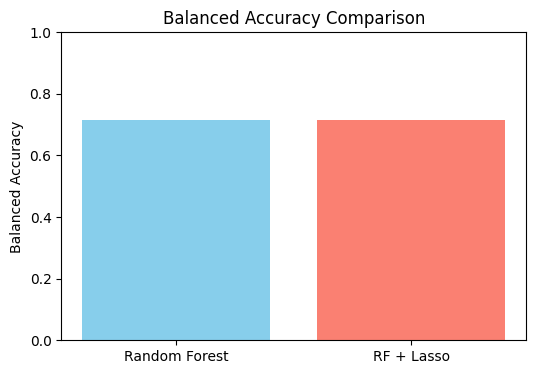

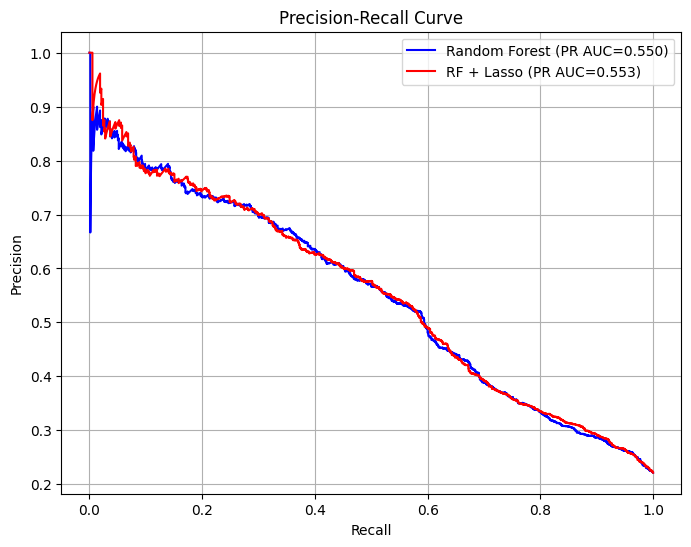

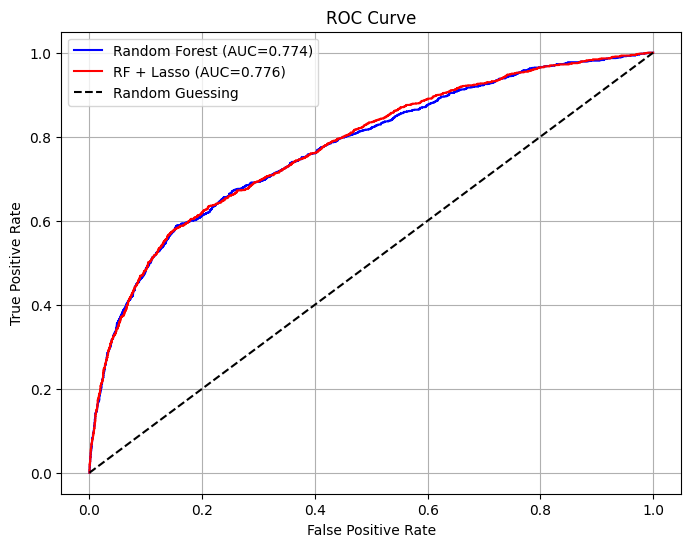

In [ ]:
# Balanced Accuracy Bar Plot
bal_acc_rf = balanced_accuracy_score(y_test, best_rf.predict(X_test))
bal_acc_sel = balanced_accuracy_score(y_test, best_rf_sel.predict(X_test))

plt.figure(figsize=(6, 4))
plt.bar(['Random Forest', 'RF + Lasso'], [bal_acc_rf, bal_acc_sel], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Comparison')
plt.show()

# Precision-Recall Curve
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
y_proba_sel = best_rf_sel.predict_proba(X_test)[:, 1]
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf)
prec_sel, rec_sel, _ = precision_recall_curve(y_test, y_proba_sel)
pr_auc_rf = average_precision_score(y_test, y_proba_rf)
pr_auc_sel = average_precision_score(y_test, y_proba_sel)

plt.figure(figsize=(8, 6))
plt.plot(rec_rf, prec_rf, label=f'Random Forest (PR AUC={pr_auc_rf:.3f})', color='blue')
plt.plot(rec_sel, prec_sel, label=f'RF + Lasso (PR AUC={pr_auc_sel:.3f})', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_sel, tpr_sel, _ = roc_curve(y_test, y_proba_sel)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_sel = auc(fpr_sel, tpr_sel)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_rf:.3f})', color='blue')
plt.plot(fpr_sel, tpr_sel, label=f'RF + Lasso (AUC={roc_auc_sel:.3f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

## Save the best model

We package the experiment for reuse: save both trained models, stash the exact test split, and record the Lasso-selected feature names, so anyone can reload, validate, or deploy the work without rerunning the notebook.

In [24]:
joblib.dump(best_rf,      MODEL_DIR / f"rf_full.joblib",   compress=3)
joblib.dump(best_rf_sel,  MODEL_DIR / f"rf_lasso.joblib",  compress=3)

print("\nModels saved in:", MODEL_DIR)

with open(MODEL_DIR / f"test_split.pkl", "wb") as f:
    pickle.dump((X_test, y_test), f)

sel_mask = best_rf_sel.named_steps['sel'].get_support()
feat_all = best_rf_sel.named_steps['prep'].get_feature_names_out()
pickle.dump(feat_all[sel_mask], open(MODEL_DIR / f"rf_lasso_features.pkl", "wb"))


Models saved in: assets\models
